In [1]:
import pickle
import datetime
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from libs_unet.models import peakyfinder_0001
from libs_unet.training.libs_train import train_loop, test_loop

top_dir = Path.cwd()
datapath = top_dir / 'data'

In [2]:
#reference data load
#elem_symb = np.loadtxt(datapath / "abundance/elements_94.csv", dtype=str)
#Leverage PyTorch native Dataset and DataLoader 
#Define Train/Test sets from 20 element data samples
with open(datapath / 'training/el77_pairs.pickle', 'rb') as f:
    fracs = pickle.load(f)
    wave = pickle.load(f)
    x_data = pickle.load(f)
    y_data = pickle.load(f)
    el_symbol = pickle.load(f)

elem_symb = el_symbol

#create dataset
#input needs a placeholder "channel" dimension since single channel
#learned labels already has max_z + 2 channels from spec_array
#data has to match weights which default to float() so cast data as same
rel_int_scale = 10**4
input_scale = 5
x_data = torch.tensor(x_data[:,None,:].astype('float32'))
y_data = torch.tensor(y_data.astype('float32'))
x_data[x_data < 0] = 0
y_data[y_data < 0] = 0
#log transform data, add small offset 1 so zero points remain ~zero on log scale
x_data = input_scale * torch.log(rel_int_scale * x_data + 1)
y_data = input_scale * torch.log(rel_int_scale * y_data + 1)

spec_ds = TensorDataset(x_data, y_data)
#batch sizes
train_bs = 50
test_bs = 100
#create random split for training and validation
train_len = int(0.8 * len(x_data))
test_len = len(x_data) - train_len
train_ds, test_ds = random_split(spec_ds,[train_len, test_len])
train_dl = DataLoader(train_ds, batch_size=train_bs, shuffle=True) #check if shuffle redundant
test_dl = DataLoader(test_ds, batch_size=test_bs)
#

Apply training optimization from 
 https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
 https://pytorch.org/tutorials/beginner/nn_tutorial.html
Notes: 
1. Run dataloader cell first, set batch size/file as needed
2. Simulated data is built on first n elements with 760 point spectra (190nm - 949nm)
3. Set this parameter so correct model size is built

In [3]:
#set parameters
from torch.optim import lr_scheduler

max_z = 77
wl_points = 760 #number of wavelength point measurements in data
learning_rate = 0.1 #There is a schedule to reduce as loss plateaus
#lr_patience = 10
#lr_cooldown = 2
#lr_thresh = 0.01
epochs = 50

#Initialize and run
model = peakyfinder_0001.LIBSUNet(max_z, wl_points)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = MultiStepLR(optimizer, [20,40], 0.5)
#lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=lr_patience,
#                                 cooldown=lr_cooldown, threshold=lr_thresh)

now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') #  now 
writerpath = top_dir / 'runs' / now_time
writer = SummaryWriter(writerpath)
                            
# save trained model
#torch.save(model, top_dir / 'trained_models/peakyfinder_0001_')

#add model diagram to tensorboard
#writer.add_graph(model,train_ds)

for t in range(epochs):
    print(f"Epoch {t+1}, learning rate {optimizer.param_groups[0]['lr']}\n-------------------------------")
    train_loop(train_dl, model, loss_fn, optimizer, writer, t+1, debug=True, bsize=train_bs)
    test_loss = test_loop(test_dl, model, loss_fn, writer, t+1)
    lr_scheduler.step()
print("Done!")

#cleanup
writer.flush()
writer.close()


Epoch 1, learning rate 0.1
-------------------------------
Epoch 2, learning rate 0.1
-------------------------------
Epoch 3, learning rate 0.1
-------------------------------
Epoch 4, learning rate 0.1
-------------------------------
Epoch 5, learning rate 0.1
-------------------------------
Epoch 6, learning rate 0.1
-------------------------------
Epoch 7, learning rate 0.1
-------------------------------
Epoch 8, learning rate 0.1
-------------------------------
Epoch 9, learning rate 0.1
-------------------------------
Epoch 10, learning rate 0.1
-------------------------------
Epoch 11, learning rate 0.1
-------------------------------
Epoch 12, learning rate 0.1
-------------------------------
Epoch 13, learning rate 0.1
-------------------------------
Epoch 14, learning rate 0.1
-------------------------------
Epoch 15, learning rate 0.1
-------------------------------
Epoch 16, learning rate 0.1
-------------------------------
Epoch 17, learning rate 0.1
---------------------

In [4]:
#Save model parameters for use in Model_Test notebook
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
param_path = top_dir / 'trained_models' / 'el77_pairs_0001'
torch.save(model.state_dict(), param_path)

In [7]:
#look at the predicted vs. reference spectra from data set
i_samp = 8000 #vary up to 
x_sample = x_data[i_samp][None, :, :] #need correct dimensions with batch for prediction
y_sample = y_data[i_samp].detach().numpy() #[79][760] # 77+2 (el + art + noi) spectra

sum x: 1.0
Ba: 0.900000
Pt: 0.100000


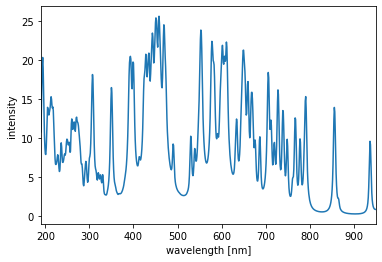

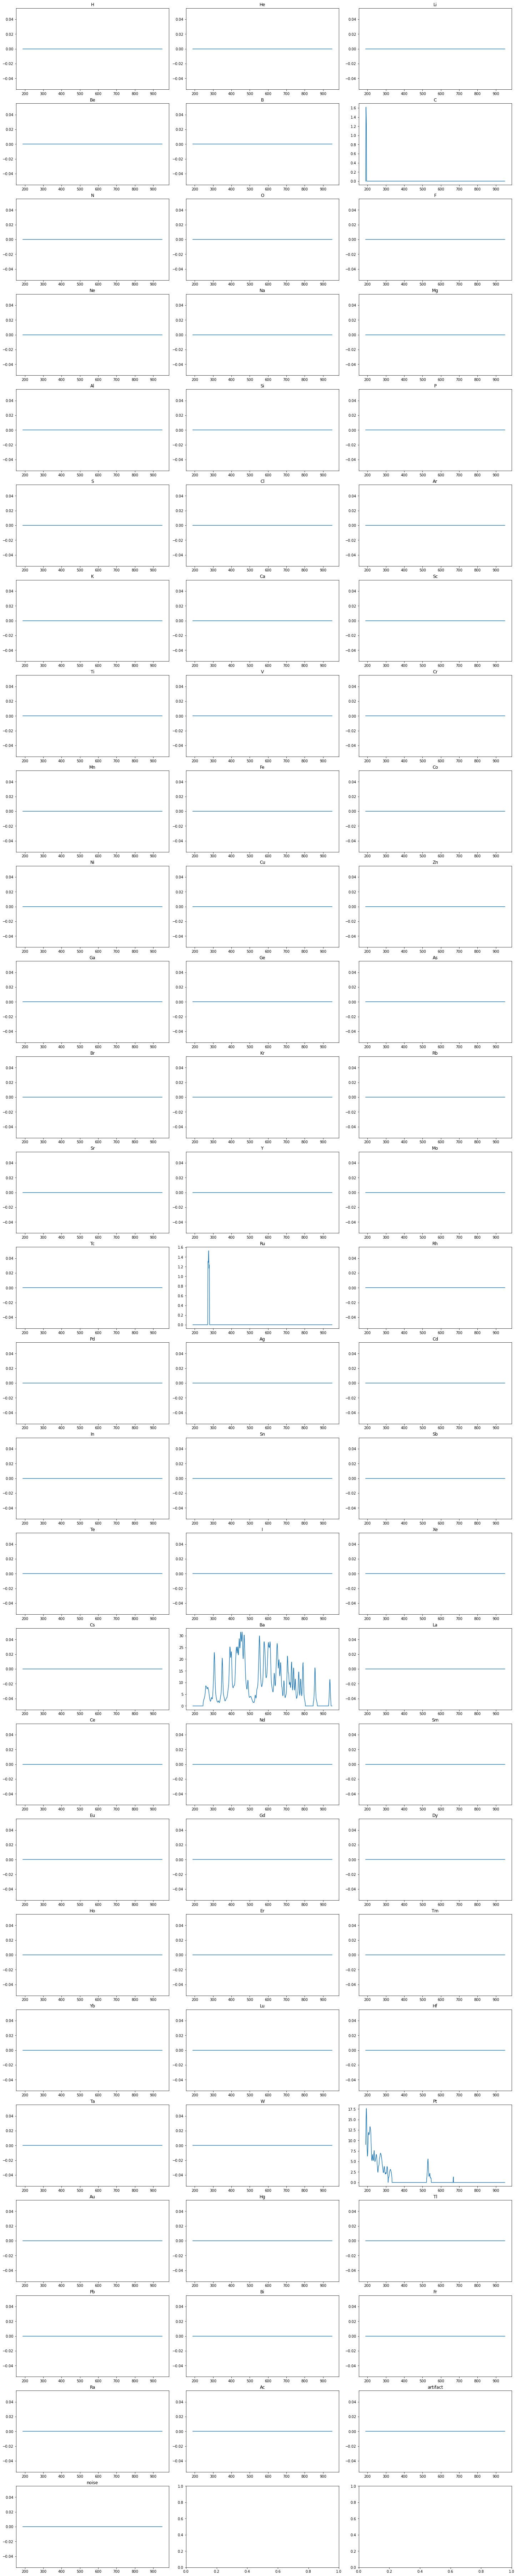

In [8]:
#composite spectra and components
#x_data = input_scale * torch.log(rel_int_scale * x_data + 1)
print(f"sum x: {torch.sum((torch.exp(x_sample[0][0]/input_scale) - 1)/rel_int_scale)}")
#show the element fractions
for i in range(max_z):
    frac = np.sum((np.exp(y_sample[i]/input_scale) - 1)/rel_int_scale)
    if frac > 0:
        print(f"{elem_symb[i]}: {frac:>4f}")
        
#first plot the transformed composite input spectrum we're trying to decompose
plt.plot(wave, x_sample[0][0])
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.show

#prediction (also transformed at this point)
plot_thresh = 1
model.eval()
with torch.no_grad():
    pred = model(x_sample)
    y_pred = pred[0].detach().numpy() #[max_z+2][760] corresponding predictions for y_sample
    y_pred[y_pred < plot_thresh] = 0

    #https://matplotlib.org/3.5.0/tutorials/introductory/usage.html#the-object-oriented-interface-and-the-pyplot-interface
    def pred_plot(ax, data1, data2, param_dict):
        out = ax.plot(data1, data2, **param_dict)
        return out

    rows = 27
    cols = 3
    fig, axs = plt.subplots(rows, cols, figsize=(20,100), constrained_layout=True)
    plot_row = 0
    plot_col = 0
    for i in range(max_z + 2): #iterate over rows in pred array
        if i < max_z:
            axs[plot_row][plot_col].set_title(el_symbol[i])
        elif i == max_z:
            axs[plot_row][plot_col].set_title('artifact')
        else:
             axs[plot_row][plot_col].set_title('noise')
             
        axs[plot_row][plot_col].plot(wave, y_pred[i])
        if plot_col < 2:
            plot_col += 1
        else:
            plot_col = 0
            plot_row += 1